<a href="https://colab.research.google.com/github/Nivarad/Transfer-Learning-Tutorial/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Pre-trained CNN Models for Medical Image Classification

This lesson demonstrates how to leverage transfer learning with pre-trained deep neural networks (ResNet50 and VGG16) to classify medical images using TensorFlow and Keras. We will work with the Chest X-Ray dataset to build a binary classifier that distinguishes between normal and pneumonia cases.

# Section 1: Imports and Setup

## 1.1 What is GPU and Why Do We Need It?

A GPU (Graphics Processing Unit) is a specialized processor originally designed for rendering graphics and images. Unlike a CPU (Central Processing Unit), which has fewer cores optimized for sequential processing, **a GPU contains thousands of smaller cores designed for parallel processing**. This makes GPUs exceptionally well-suited for deep learning tasks.

When training neural networks, we perform **millions of matrix multiplications and mathematical operations.** CPUs process these operations sequentially, while GPUs can perform thousands of calculations simultaneously. For deep learning, this translates to training times that are 10-100x faster on a GPU compared to a CPU.

Google Colab provides free access to GPU runtime, making it an excellent platform for training deep learning models without expensive hardware.

## 1.2 Setting Up GPU in Google Colab

Before we begin training, we need to enable and connect to a GPU in Google Colab.

### **How to Enable GPU (Do this FIRST):**

**Step 1: Change Runtime Type**
1. Click on **Runtime** in the top menu
2. Select **Change runtime type**
3. In the popup window, select **Hardware accelerator: GPU**
4. Click **Save**

**Step 2: Connect to Runtime**
1. Click the **Connect** button in the top-right corner of the Colab interface
2. Wait for the connection to be established (the button will show "Connected" with a green checkmark)
3. This allocates GPU resources to your notebook

**Step 3: Verify GPU is Active**
Run the cells below to verify that GPU is available and properly configured.


In [ ]:
import tensorflow as tf  # Import TensorFlow for deep learning

# Display TensorFlow version
print('TensorFlow version:', tf.__version__)

# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')  # List all GPU devices
print('Number of GPUs Available:', len(gpus))  # Print count of GPUs

# Provide user feedback on GPU availability
if len(gpus) > 0:
    print('GPU is available and ready to use!')
    print('GPU Details:')
    for gpu in gpus:
        print(f'  {gpu}')  # Print each GPU device name
else:
    print('No GPU found. Please enable GPU in Runtime > Change runtime type > GPU')

TensorFlow version: 2.19.0
Number of GPUs Available: 0
No GPU found. Please enable GPU in Runtime > Change runtime type > GPU


In [ ]:
# Check GPU specifications using nvidia-smi (NVIDIA System Management Interface)
# This shows GPU model, memory usage, temperature, and utilization
!nvidia-smi

In [ ]:
# Configure TensorFlow to use GPU memory efficiently
if len(gpus) > 0:
    try:
        # Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPU memory growth enabled - TensorFlow will use GPU for training')

        # Set the default device to GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f'Default training device set to: {gpus[0].name}')

    except RuntimeError as e:
        print(f'GPU configuration error: {e}')
else:
    print('WARNING: No GPU detected. Training will run on CPU (this will be MUCH slower)')

## 1.3 Installing Required Libraries

We'll import all necessary libraries for our transfer learning workflow. TensorFlow provides the deep learning framework, while additional libraries help with data manipulation, visualization, and evaluation.

In [ ]:
# Core libraries
import numpy as np  # For numerical operations and array manipulation
import matplotlib.pyplot as plt  # For plotting and visualization
import seaborn as sns  # For advanced statistical visualizations
import os  # For file and directory operations
import random  # For random sampling
import pandas as pd  # For data manipulation and display

# TensorFlow and Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # Data augmentation and image loading
from tensorflow.keras.applications import ResNet50, VGG16  # Pre-trained model architectures
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout  # Layers for custom head
from tensorflow.keras.models import Model  # Model class for creating custom models
from tensorflow.keras.optimizers import Adam  # Adam optimizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Training callbacks
from tensorflow.keras.preprocessing import image  # Image preprocessing utilities

# Scikit-learn imports for evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight  # For handling class imbalance

# Google Colab specific
from google.colab import files  # For file upload in Colab

# Set random seeds for reproducibility across runs
np.random.seed(42)  # Set NumPy random seed
tf.random.set_seed(42)  # Set TensorFlow random seed

print('All libraries imported successfully!')

# Section 2: Data Downloading and Preprocessing

## 2.1 Downloading the Chest X-Ray Dataset

We will use the Chest X-Ray Pneumonia dataset from Kaggle, which contains **labeled chest X-ray images for binary classification: Normal vs. Pneumonia.**

### **How to Get Your Kaggle API Token (kaggle.json):**

**Before running the cells below, follow these steps:**

1. **Go to** www.kaggle.com **and sign in** (or create a free account if you don't have one)
2. **Click on your profile picture** in the top-right corner
3. **Select 'Settings'** from the dropdown menu
4. **Scroll down to the 'API' section**
5. **Click 'Create New API Token'** button
6. **This will download a file called** `kaggle.json` **to your computer**
7. **Remember where you saved this file** (usually in your Downloads folder)

When you run the upload cell below, you'll need to click 'Choose Files' and select this `kaggle.json` file.

In [ ]:
# Install Kaggle API package for downloading datasets
!pip install -q kaggle  # -q flag means quiet mode (minimal output)

In [ ]:
# Upload your kaggle.json file
print('Please upload your kaggle.json file:')
print('(Click the "Choose Files" button and select the kaggle.json you downloaded)')
uploaded = files.upload()  # Opens file chooser dialog for uploading

In [ ]:
# Configure Kaggle API credentials
!mkdir -p ~/.kaggle  # Create .kaggle directory in home folder if it doesn't exist
!mv kaggle.json ~/.kaggle/  # Move uploaded kaggle.json to the .kaggle directory
!chmod 600 ~/.kaggle/kaggle.json  # Set file permissions to read/write for owner only (security requirement)
print('Kaggle API configured successfully!')

In [ ]:
# Download the Chest X-Ray Pneumonia dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia  # Download dataset as zip file
print('Dataset downloaded successfully!')

In [ ]:
# Extract the downloaded dataset
!unzip -q chest-xray-pneumonia.zip -d ./data  # -q for quiet mode, -d specifies destination directory
print('Dataset extracted successfully!')

## 2.2 Exploring the Dataset Structure

### Understanding the Classification Task

**What is Pneumonia?**
Pneumonia is an infection that inflames the air sacs in one or both lungs, which may **fill with fluid. On chest X-rays, pneumonia appears as white or cloudy areas in the lung fields, while healthy lungs appear darker due to air-filled spaces.**

**Dataset Information:**
This dataset contains chest **X-ray images from pediatric patients,** labeled into two categories:
- **NORMAL**: Healthy lungs with clear air passages
- **PNEUMONIA**: Lungs showing signs of infection with fluid or inflammatory markers

The images were collected from routine clinical care and represent real-world diagnostic scenarios. Our goal is to build a model that can automatically detect pneumonia from X-ray images, potentially assisting radiologists in faster diagnosis.

Understanding the dataset structure is crucial before preprocessing. The Chest X-Ray dataset is organized into three folders: train, val (validation), and test. Each folder contains two subfolders representing the two classes: NORMAL and PNEUMONIA.

In [ ]:
# Define paths to data directories
data_dir = './data/chest_xray'  # Root directory of the dataset
train_dir = os.path.join(data_dir, 'train')  # Training data directory
val_dir = os.path.join(data_dir, 'val')  # Validation data directory
test_dir = os.path.join(data_dir, 'test')  # Test data directory

# Count images in each category by listing files in directories
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))  # Count normal training images
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))  # Count pneumonia training images
val_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))  # Count normal validation images
val_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))  # Count pneumonia validation images
test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))  # Count normal test images
test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))  # Count pneumonia test images

# Display dataset distribution
print('Dataset Distribution:')
print(f'Training set - NORMAL: {train_normal}, PNEUMONIA: {train_pneumonia}')
print(f'Validation set - NORMAL: {val_normal}, PNEUMONIA: {val_pneumonia}')
print(f'Test set - NORMAL: {test_normal}, PNEUMONIA: {test_pneumonia}')
print(f'\nTotal images: {train_normal + train_pneumonia + val_normal + val_pneumonia + test_normal + test_pneumonia}')

# Calculate and display imbalance ratio
train_ratio = train_pneumonia / train_normal
print(f'\nClass Imbalance Ratio (Training): {train_ratio:.2f}:1 (Pneumonia:Normal)')
print('This dataset is imbalanced - we will use class weights and F1-score to address this.')

In [ ]:
# Visualize class distribution across train, validation, and test sets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # Create 1 row, 3 columns of subplots

# Prepare data for visualization
datasets = ['Training', 'Validation', 'Test']  # Dataset names
normal_counts = [train_normal, val_normal, test_normal]  # Normal image counts
pneumonia_counts = [train_pneumonia, val_pneumonia, test_pneumonia]  # Pneumonia image counts

# Create bar chart for each dataset
for i, ax in enumerate(axes):
    ax.bar(['Normal', 'Pneumonia'], [normal_counts[i], pneumonia_counts[i]], color=['blue', 'red'])  # Create bar chart
    ax.set_title(f'{datasets[i]} Set')  # Set subplot title
    ax.set_ylabel('Number of Images')  # Set y-axis label

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the plot

## 2.3 Data Augmentation and Preparation

Data augmentation is a technique that artificially increases the diversity of our training dataset by applying random transformations to images. This helps prevent overfitting and improves the model's ability to generalize to new, unseen data.

We use Keras' ImageDataGenerator to apply transformations such as:
- rescale: Normalizes pixel values from [0, 255] to [0, 1]
- rotation_range: Randomly rotates images by up to 10 degrees
- width_shift_range / height_shift_range: Randomly shifts images horizontally or vertically
- zoom_range: Randomly zooms in or out
- horizontal_flip: Randomly flips images horizontally

**Note:** During training, each image can be augmented multiple times with different random transformations. This effectively multiplies the number of unique training samples without requiring additional storage. For our training set of 5,216 images, **augmentation will generate new variations on-the-fly during each epoch**.

For validation and test sets, we only apply rescaling without augmentation to ensure consistent evaluation.

In [ ]:
# Define image size and batch size constants
IMG_SIZE = (224, 224)  # Target size for images (required by ResNet50 and VGG16)
BATCH_SIZE = 32  # Number of images to process in each batch

# Training data augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=10,           # Rotate images randomly up to 10 degrees (reduced for faster training)
    width_shift_range=0.1,       # Shift images horizontally by up to 10%
    height_shift_range=0.1,      # Shift images vertically by up to 10%
    zoom_range=0.1,              # Zoom in/out by up to 10%
    horizontal_flip=True,        # Randomly flip images horizontally (50% chance)
    fill_mode='nearest'          # Fill empty pixels after transformations with nearest pixel value
)

# Validation and test data generator - only rescaling, no augmentation
val_test_datagen = ImageDataGenerator(
    rescale=1./255  # Only normalize pixel values, no random transformations
)

print('Data generators created successfully!')
print(f'\nAugmentation creates new variations on-the-fly during training.')
print(f'Original training images: {train_normal + train_pneumonia}')
print(f'With augmentation, each epoch sees different variations of these images.')

In [ ]:
# Create data generators from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing training images
    target_size=IMG_SIZE,  # Resize all images to 224x224
    batch_size=BATCH_SIZE,  # Number of images per batch
    class_mode='binary',  # Binary classification (0 or 1)
    shuffle=True  # Shuffle images for each epoch
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,  # Directory containing validation images
    target_size=IMG_SIZE,  # Resize all images to 224x224
    batch_size=BATCH_SIZE,  # Number of images per batch
    class_mode='binary',  # Binary classification (0 or 1)
    shuffle=False  # Don't shuffle validation data for consistent evaluation
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,  # Directory containing test images
    target_size=IMG_SIZE,  # Resize all images to 224x224
    batch_size=BATCH_SIZE,  # Number of images per batch
    class_mode='binary',  # Binary classification (0 or 1)
    shuffle=False  # Don't shuffle test data for consistent evaluation
)

# Display class-to-index mapping (NORMAL=0, PNEUMONIA=1)
print(f'Class indices: {train_generator.class_indices}')

In [ ]:
# Visualize different types of augmentations separately

# Load a sample image
sample_image_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_img = load_img(sample_image_path, target_size=IMG_SIZE)  # Load and resize image
sample_array = img_to_array(sample_img)  # Convert to numpy array
sample_array = np.expand_dims(sample_array, axis=0)  # Add batch dimension

# Define specific augmentation types for demonstration
augmentation_types = {
    'Original': ImageDataGenerator(rescale=1./255),
    'Rotation': ImageDataGenerator(rescale=1./255, rotation_range=20),
    'Horizontal Flip': ImageDataGenerator(rescale=1./255, horizontal_flip=True),
    'Zoom': ImageDataGenerator(rescale=1./255, zoom_range=0.2),
    'Width Shift': ImageDataGenerator(rescale=1./255, width_shift_range=0.2),
    'Height Shift': ImageDataGenerator(rescale=1./255, height_shift_range=0.2),
}

# Create visualization with 2 examples per augmentation type
fig, axes = plt.subplots(6, 2, figsize=(10, 16))  # 6 rows, 2 columns

for i, (aug_name, datagen) in enumerate(augmentation_types.items()):
    # Generate 2 augmented examples
    aug_iter = datagen.flow(sample_array, batch_size=1)

    # First example
    aug_img1 = next(aug_iter)[0]  # Get first augmented image
    axes[i, 0].imshow(aug_img1)  # Display image
    axes[i, 0].set_title(f'{aug_name} - Example 1', fontsize=10)
    axes[i, 0].axis('off')  # Hide axes

    # Second example (generate new augmentation)
    aug_img2 = next(aug_iter)[0]  # Get second augmented image
    axes[i, 1].imshow(aug_img2)  # Display image
    axes[i, 1].set_title(f'{aug_name} - Example 2', fontsize=10)
    axes[i, 1].axis('off')  # Hide axes

plt.suptitle('Data Augmentation Examples - 2 Samples per Technique', fontsize=14, y=0.995)
plt.tight_layout()  # Adjust spacing
plt.show()  # Display the plot

# Section 3: Transfer Learning

## 3.1 What is Transfer Learning?

Transfer learning is a machine learning technique where a model trained on one task is reused as the starting point for a model on a different but related task. Instead of training a neural network from scratch, **we leverage pre-trained models that have already learned rich feature representations from large datasets like ImageNet (1.4 million images, 1000 classes).**

The key advantage is that **lower layers of CNNs learn general features (edges, textures, shapes) that are useful across many vision tasks.** By using these pre-trained weights, we can achieve high accuracy even with limited training data, reduce training time significantly, and avoid the computational cost of training deep networks from scratch.

## 3.2 Understanding ResNet50 and VGG16 Architectures

**ResNet50 (Residual Network with 50 layers)** introduced skip connections or residual blocks that allow gradients to flow directly through the network. This architecture solves the vanishing gradient problem in very deep networks. The residual learning framework uses the equation y = F(x) + x, where F(x) represents learned residual mapping and x is the identity shortcut connection.



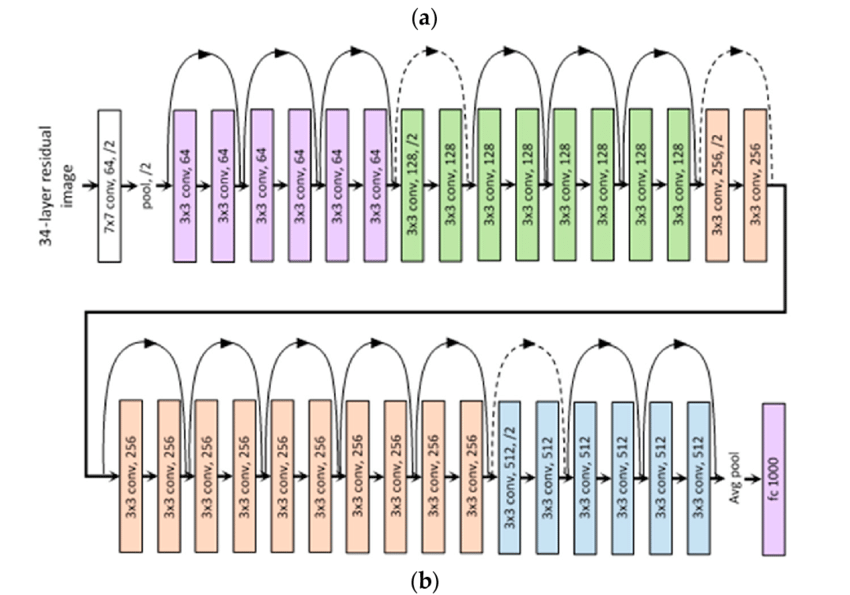

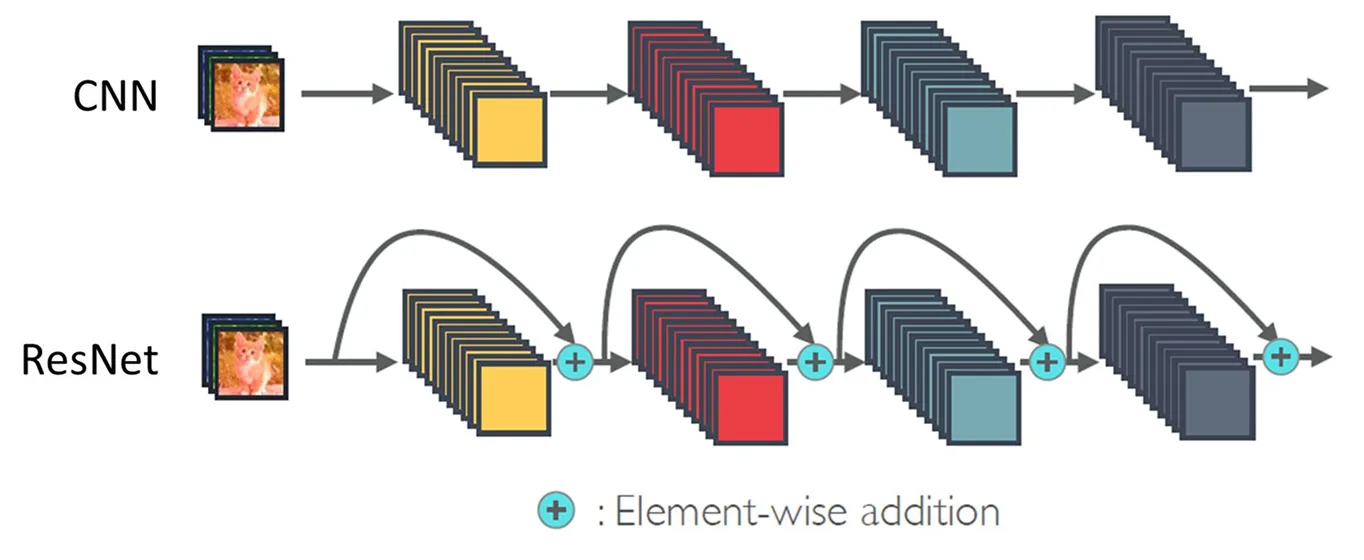

**VGG16 (Visual Geometry Group with 16 layers)** uses a simple and uniform architecture with stacked 3x3 convolutional filters. While it has more parameters than ResNet, its straightforward design makes it easy to understand and implement. VGG16 was one of the first networks to demonstrate that depth significantly improves performance.



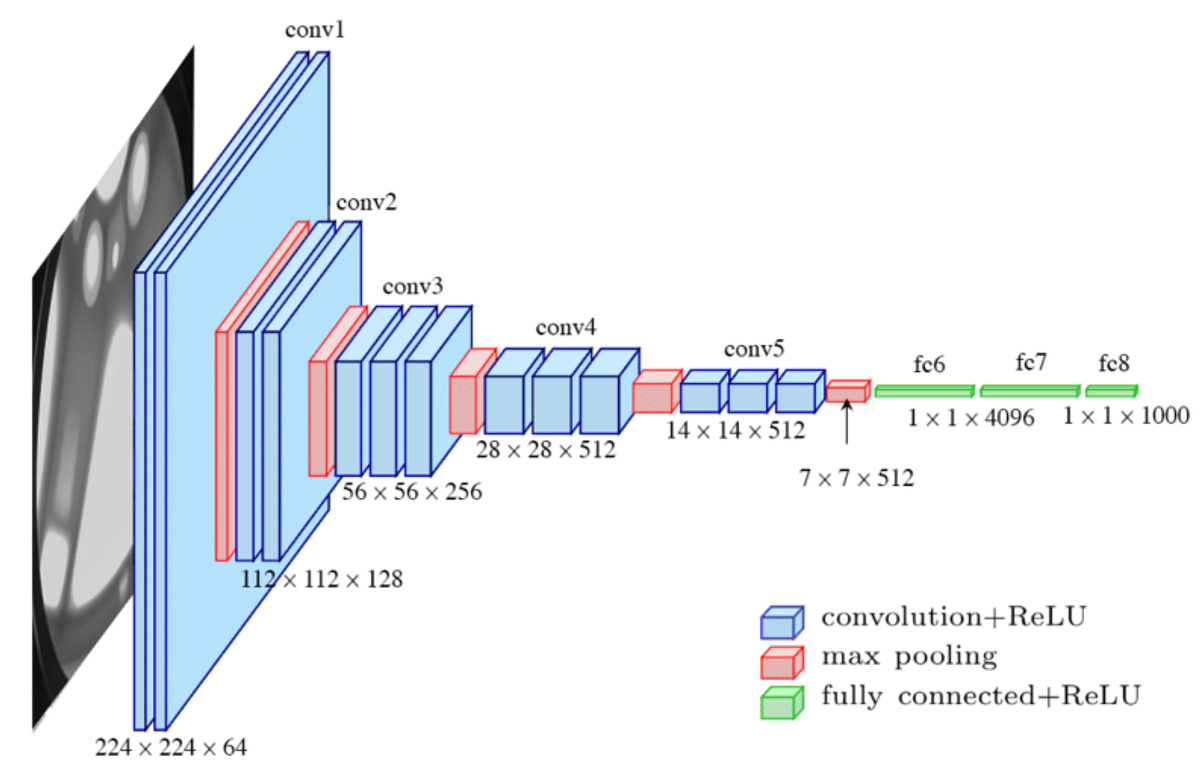

Both models were pre-trained on ImageNet and have proven highly effective for transfer learning across various computer vision tasks.

## 3.3 Loading Pre-trained Models

We load ResNet50 and VGG16 with weights pre-trained on ImageNet. **By setting include_top=False, we exclude the original classification head (designed for 1000 ImageNet classes) and add our own custom layers for binary classification.**

Our custom classification head consists of:
- GlobalAveragePooling2D: Reduces spatial dimensions by averaging
- Dense layer with 256 units and ReLU activation: Learns task-specific features
- Dropout layer (0.5): Prevents overfitting by randomly dropping connections
- Output Dense layer with 1 unit and sigmoid activation: Produces probability for binary classification

![image.png](|)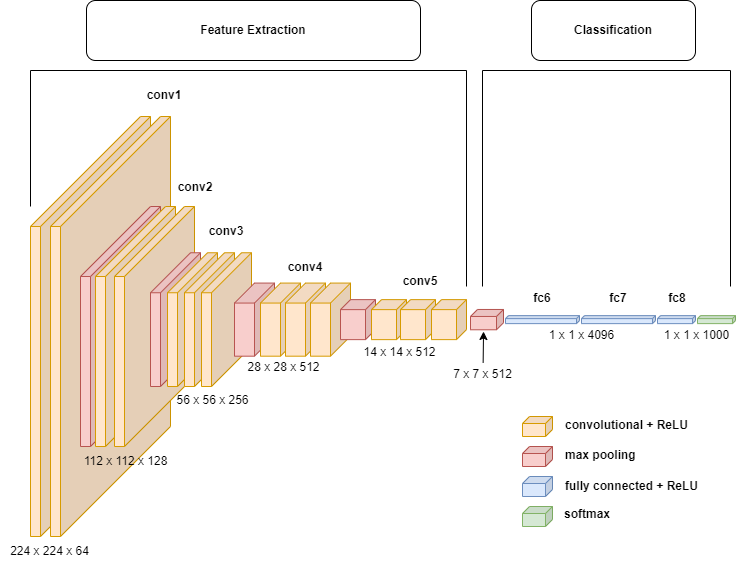

## 3.4 Evaluating Pre-trained Models with Original ImageNet Classification Head

Before building our custom models, let's first evaluate the original pre-trained models with their ImageNet classification heads. These models were trained to classify 1000 ImageNet categories (cats, dogs, cars, etc.) - not medical images. This will show us how pre-trained models perform without any adaptation to our pneumonia detection task.

We load models with `include_top=True` to keep the original 1000-class classification head.


In [ ]:
# Load ResNet50 with original ImageNet classification head (1000 classes)
print('Loading ResNet50 with original ImageNet head...')
resnet_pretrained = ResNet50(
    weights='imagenet',  # Use pre-trained ImageNet weights
    include_top=True,  # KEEP the original classification head for ImageNet (1000 classes)
    input_shape=IMG_SIZE + (3,)  # Input shape: 224x224x3
)

print(f'ResNet50 (ImageNet) created with {resnet_pretrained.count_params():,} parameters')
print('This model outputs predictions for 1000 ImageNet classes (not pneumonia!)')


In [ ]:
# Load VGG16 with original ImageNet classification head (1000 classes)
print('Loading VGG16 with original ImageNet head...')
vgg_pretrained = VGG16(
    weights='imagenet',  # Use pre-trained ImageNet weights
    include_top=True,  # KEEP the original classification head for ImageNet (1000 classes)
    input_shape=IMG_SIZE + (3,)  # Input shape: 224x224x3
)

print(f'VGG16 (ImageNet) created with {vgg_pretrained.count_params():,} parameters')
print('This model outputs predictions for 1000 ImageNet classes (not pneumonia!)')


### Evaluating ImageNet Models on Medical Data

Since these models output 1000 ImageNet class probabilities (not binary pneumonia predictions), we cannot directly evaluate accuracy. However, we can examine what the models "think" they're seeing in chest X-rays. This demonstrates why we need transfer learning - these models weren't designed for medical imaging!

Let's look at a few sample predictions to see what ImageNet categories the model predicts for chest X-rays.


In [ ]:
# Load ImageNet class labels
import urllib.request
import json

# Download ImageNet class labels
class_idx_url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
with urllib.request.urlopen(class_idx_url) as url:
    imagenet_classes = json.loads(url.read().decode())

# Convert to list of class names
imagenet_class_names = [imagenet_classes[str(i)][1] for i in range(1000)]

print('ImageNet classes loaded (1000 categories)')
print('Sample categories:', imagenet_class_names[:10])


In [ ]:
# Function to show what pre-trained ImageNet models predict on chest X-rays
def show_imagenet_predictions(model, generator, model_name, num_samples=3):
    """Show top-5 ImageNet predictions for sample chest X-rays"""
    print(f'\n=== {model_name} ImageNet Predictions on Chest X-rays ===')

    # Get a batch of images
    images, labels = next(generator)

    for i in range(min(num_samples, len(images))):
        # Make prediction
        img = np.expand_dims(images[i], axis=0)
        predictions = model.predict(img, verbose=0)[0]

        # Get top 5 predictions
        top5_idx = predictions.argsort()[-5:][::-1]

        actual_class = 'NORMAL' if labels[i] == 0 else 'PNEUMONIA'
        print(f'\nImage {i+1} - Actual: {actual_class}')
        print('Top 5 ImageNet predictions:')
        for idx in top5_idx:
            print(f'  {imagenet_class_names[idx]}: {predictions[idx]*100:.2f}%')

    generator.reset()

# Show predictions for both models
show_imagenet_predictions(resnet_pretrained, test_generator, 'ResNet50')
show_imagenet_predictions(vgg_pretrained, test_generator, 'VGG16')


### Key Observation

Notice that the pre-trained models predict random ImageNet categories like "stethoscope", "oxygen_mask", "lab_coat", or completely unrelated objects. This demonstrates:

1. **Pre-trained models don't understand medical images** - they were trained on everyday objects
2. **We cannot use them directly** - the output classes are wrong for our task
3. **Transfer learning is essential** - we need to replace the classification head and adapt the model

This is why we build custom models in the next section with `include_top=False` - we remove the ImageNet head and add our own binary classification head for pneumonia detection.


## 3.5 Building Custom Models and Baseline Evaluation

Now we build our custom models by removing the ImageNet classification head (`include_top=False`) and adding our own binary classification head for pneumonia detection. We'll first evaluate these models with random weights in the custom head (baseline) before training.


In [ ]:
# Load ResNet50 base model with ImageNet weights
print('Loading ResNet50...')
resnet_base = ResNet50(
    weights='imagenet',  # Use weights pre-trained on ImageNet dataset
    include_top=False,  # Exclude the original classification layers (top)
    input_shape=IMG_SIZE + (3,)  # Input shape: 224x224x3 (height, width, RGB channels)
)

# Build custom classification head for ResNet50
x = GlobalAveragePooling2D()(resnet_base.output)  # Reduce spatial dimensions to single vector per feature map
x = Dense(256, activation='relu')(x)  # Fully connected layer with 256 neurons and ReLU activation
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting (randomly drops 50% of connections)
output = Dense(1, activation='sigmoid')(x)  # Output layer with 1 neuron and sigmoid for binary classification (0-1)
resnet_model = Model(inputs=resnet_base.input, outputs=output, name='ResNet50_Custom')  # Create final model

print(f'ResNet50 model created with {resnet_model.count_params():,} total parameters')

In [ ]:
################ TO-DO ################
# Load VGG16 base model with ImageNet weights
print('Loading VGG16...')
vgg_base =

# Build custom classification head for VGG16


# Final model
vgg_model =

################ TO-DO ################
print(f'VGG16 model created with {vgg_model.count_params():,} total parameters')

### Baseline Evaluation Setup

Before training, we compile the models and evaluate them on the test set. At this point:
- **Pre-trained layers**: Have ImageNet weights (frozen, will be used for feature extraction)
- **Custom classification head**: Has RANDOM weights (untrained)

This baseline shows performance with pre-trained features but an untrained classification head - essentially random guessing for pneumonia detection.


In [ ]:
# Compile models with random weights in classification head for baseline evaluation
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Adam optimizer
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=['accuracy']  # Track accuracy
)

vgg_model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Adam optimizer
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=['accuracy']  # Track accuracy
)

print('Models compiled for baseline evaluation')

In [ ]:
# Function to evaluate model and calculate metrics using sklearn
def evaluate_and_get_metrics(model, generator, model_name):
    """Evaluate model and return metrics as dictionary"""
    # Generate predictions
    predictions_probs = model.predict(generator, verbose=0)  # Get probability predictions
    predictions = (predictions_probs > 0.5).astype(int).flatten()  # Convert to binary (0 or 1)
    true_labels = generator.classes  # Get true labels from generator

    # Calculate metrics using sklearn functions
    f1 = f1_score(true_labels, predictions)  # F1 score (harmonic mean of precision and recall)
    precision = precision_score(true_labels, predictions)  # Precision (true positives / predicted positives)
    recall = recall_score(true_labels, predictions)  # Recall (true positives / actual positives)
    accuracy = np.mean(predictions == true_labels)  # Accuracy (correct predictions / total)

    # Print results
    print(f'{model_name}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1-Score: {f1:.4f}')

    # Return as dictionary for later comparison
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Evaluate original models (baseline - untrained classification head)
print('\n=== Baseline: Original Models (Untrained Classification Head) ===')
resnet_baseline = evaluate_and_get_metrics(resnet_model, test_generator, 'ResNet50 (Baseline)')
test_generator.reset()  # Reset generator to start from beginning
vgg_baseline = evaluate_and_get_metrics(vgg_model, test_generator, 'VGG16 (Baseline)')
test_generator.reset()  # Reset generator to start from beginning

## 3.6 Fine-tuning Strategy: Two-Stage Training

### Understanding Callbacks

Callbacks are automated functions that execute at specific points during training. They monitor performance and make adjustments without manual intervention.

We use key callbacks:
- **EarlyStopping**: Stops training when validation performance stops improving
- **ModelCheckpoint**: Saves the best model automatically

### Two-Stage Training Strategy

We employ a two-stage fine-tuning strategy for optimal results:

**Stage 1 - Feature Extraction:**
We freeze all layers of the pre-trained base model and **train only the newly added classification head.** This allows the custom layers to learn appropriate weights while preserving the valuable pre-trained features. **We use a relatively high learning rate (1e-3) since only the top layers are being updated.**

**Stage 2 - Fine-tuning:**
After the classification head has converged, **we unfreeze some of the top layers** of the base model and continue training with a much lower learning rate (1e-4). This allows the pre-trained features to **adapt slightly to our specific task without destroying the learned representations.**

### Handling Class Imbalance

Since our dataset has more pneumonia cases than normal cases, we will use **class weights** during training to **penalize misclassifications of the minority class** more heavily.

### Stage 1: Feature Extraction - Training Only the Classification Head

In [ ]:
# Calculate class weights to handle imbalance
train_labels = train_generator.classes  # Get all training labels
class_weights_array = compute_class_weight(
    'balanced',  # Use balanced weighting strategy
    classes=np.unique(train_labels),  # Unique class labels [0, 1]
    y=train_labels  # All training labels
)

# Convert to dictionary format for Keras
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

print(f'Class weights calculated:')
print(f'  NORMAL (0): {class_weights[0]:.2f}')
print(f'  PNEUMONIA (1): {class_weights[1]:.2f}')
print('\nThese weights will penalize misclassifications of the minority class more heavily.')

In [ ]:
# Freeze the base models to prevent their weights from being updated
resnet_base.trainable = False  # Freeze all ResNet50 layers
vgg_base.trainable = False  # Freeze all VGG16 layers

# Count and display trainable parameters (only custom head layers)
print('Base models frozen for Stage 1 (Feature Extraction)')
print(f'ResNet50 - Trainable parameters: {sum([tf.size(w).numpy() for w in resnet_model.trainable_weights]):,}')
print(f'VGG16 - Trainable parameters: {sum([tf.size(w).numpy() for w in vgg_model.trainable_weights]):,}')

In [ ]:
# Compile models for Stage 1 training
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Higher learning rate for training new layers
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=['accuracy']  # Track accuracy
)

vgg_model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Higher learning rate for training new layers
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=['accuracy']  # Track accuracy
)

print('Models compiled for Stage 1 training')

In [ ]:
# Define callbacks for Stage 1 training
resnet_callbacks_s1 = [
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=2,  # Stop if no improvement for 2 epochs (reduced for quick training)
        restore_best_weights=True,  # Restore weights from best epoch
        verbose=1  # Print messages
    ),
    ModelCheckpoint(
        'best_resnet_stage1.keras',  # Save path (native Keras format)
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Only save when accuracy improves
        mode='max',  # Maximize accuracy
        verbose=1  # Print messages
    )
]

vgg_callbacks_s1 = [
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=2,  # Stop if no improvement for 2 epochs
        restore_best_weights=True,  # Restore weights from best epoch
        verbose=1  # Print messages
    ),
    ModelCheckpoint(
        'best_vgg_stage1.keras',  # Save path (native Keras format)
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Only save when accuracy improves
        mode='max',  # Maximize accuracy
        verbose=1  # Print messages
    )
]

print('Callbacks configured for Stage 1')

In [ ]:
# Train ResNet50 - Stage 1: Feature Extraction
print('\n' + '='*80)
print('Training ResNet50 - Stage 1: Feature Extraction')
print('='*80)
history_resnet_s1 = resnet_model.fit(
    train_generator,  # Training data generator
    epochs=3,  # Train for 3 epochs (reduced for quick demonstration)
    validation_data=val_generator,  # Validation data generator
    callbacks=resnet_callbacks_s1,  # Apply callbacks
    class_weight=class_weights,  # Apply class weights to handle imbalance
    verbose=1  # Print progress
)

In [ ]:
# Train VGG16 - Stage 1: Feature Extraction
print('\n' + '='*80)
print('Training VGG16 - Stage 1: Feature Extraction')
print('='*80)
history_vgg_s1 = vgg_model.fit(
    train_generator,  # Training data generator
    epochs=3,  # Train for 3 epochs (reduced for quick demonstration)
    validation_data=val_generator,  # Validation data generator
    callbacks=vgg_callbacks_s1,  # Apply callbacks
    class_weight=class_weights,  # Apply class weights to handle imbalance
    verbose=1  # Print progress
)

In [ ]:
# Evaluate models after Stage 1 training
print('\n' + '='*80)
print('Evaluation After Stage 1 Training')
print('='*80)
resnet_stage1 = evaluate_and_get_metrics(resnet_model, test_generator, 'ResNet50 (After Stage 1)')
test_generator.reset()  # Reset generator
vgg_stage1 = evaluate_and_get_metrics(vgg_model, test_generator, 'VGG16 (After Stage 1)')
test_generator.reset()  # Reset generator

### Stage 2: Fine-tuning - Unfreezing Top Layers

In [ ]:
# Unfreeze top layers of ResNet50 for fine-tuning
resnet_base.trainable = True  # Make base model trainable

# Freeze all layers except the last 20 layers
for layer in resnet_base.layers[:-20]:  # Iterate through all but last 20 layers
    layer.trainable = False  # Freeze each layer

print('ResNet50 - Top layers unfrozen for Stage 2')
print(f'Trainable parameters: {sum([tf.size(w).numpy() for w in resnet_model.trainable_weights]):,}')

In [ ]:
################ TO-DO ################
# Unfreeze top layers of VGG16 for fine-tuning

################ TO-DO ################

print('VGG16 - Top layers unfrozen for Stage 2')
print(f'Trainable parameters: {sum([tf.size(w).numpy() for w in vgg_model.trainable_weights]):,}')

In [ ]:
# Recompile models with lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate (0.0001) to avoid destroying pre-trained weights
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=['accuracy']  # Track accuracy
)

vgg_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate (0.0001) to avoid destroying pre-trained weights
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=['accuracy']  # Track accuracy
)

print('Models recompiled with lower learning rate for Stage 2 fine-tuning')

In [ ]:
# Define callbacks for Stage 2 training
resnet_callbacks_s2 = [
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=2,  # Stop if no improvement for 2 epochs
        restore_best_weights=True,  # Restore weights from best epoch
        verbose=1  # Print messages
    ),
    ModelCheckpoint(
        'best_resnet_stage2.keras',  # Save path (native Keras format)
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Only save when accuracy improves
        mode='max',  # Maximize accuracy
        verbose=1  # Print messages
    )
]

vgg_callbacks_s2 = [
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=2,  # Stop if no improvement for 2 epochs
        restore_best_weights=True,  # Restore weights from best epoch
        verbose=1  # Print messages
    ),
    ModelCheckpoint(
        'best_vgg_stage2.keras',  # Save path (native Keras format)
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Only save when accuracy improves
        mode='max',  # Maximize accuracy
        verbose=1  # Print messages
    )
]

print('Callbacks configured for Stage 2')

In [ ]:
# Train ResNet50 - Stage 2: Fine-tuning
print('\n' + '='*80)
print('Training ResNet50 - Stage 2: Fine-tuning')
print('='*80)
history_resnet_s2 = resnet_model.fit(
    train_generator,  # Training data generator
    epochs=3,  # Train for 3 epochs (reduced for quick demonstration)
    validation_data=val_generator,  # Validation data generator
    callbacks=resnet_callbacks_s2,  # Apply callbacks
    class_weight=class_weights,  # Apply class weights to handle imbalance
    verbose=1  # Print progress
)

In [ ]:
# Train VGG16 - Stage 2: Fine-tuning
print('\n' + '='*80)
print('Training VGG16 - Stage 2: Fine-tuning')
print('='*80)
history_vgg_s2 = vgg_model.fit(
    train_generator,  # Training data generator
    epochs=3,  # Train for 3 epochs (reduced for quick demonstration)
    validation_data=val_generator,  # Validation data generator
    callbacks=vgg_callbacks_s2,  # Apply callbacks
    class_weight=class_weights,  # Apply class weights to handle imbalance
    verbose=1  # Print progress
)

In [ ]:
# Evaluate models after Stage 2 training (Final)
print('\n' + '='*80)
print('Final Evaluation After Stage 2 Training')
print('='*80)
resnet_stage2 = evaluate_and_get_metrics(resnet_model, test_generator, 'ResNet50 (After Stage 2 - Final)')
test_generator.reset()  # Reset generator
vgg_stage2 = evaluate_and_get_metrics(vgg_model, test_generator, 'VGG16 (After Stage 2 - Final)')
test_generator.reset()  # Reset generator

## 3.7 Comprehensive Model Comparison

Let's compare all three stages for both models: baseline (untrained), after Stage 1 (feature extraction), and after Stage 2 (fine-tuning). This comparison demonstrates the progressive improvement from transfer learning.

In [ ]:
# Create comprehensive comparison table with all metrics across all stages
comparison_data = {
    'Model': [
        'ResNet50 - Baseline (Untrained)',
        'ResNet50 - After Stage 1',
        'ResNet50 - After Stage 2 (Final)',
        'VGG16 - Baseline (Untrained)',
        'VGG16 - After Stage 1',
        'VGG16 - After Stage 2 (Final)'
    ],
    'Accuracy': [
        f"{resnet_baseline['accuracy']:.4f}",
        f"{resnet_stage1['accuracy']:.4f}",
        f"{resnet_stage2['accuracy']:.4f}",
        f"{vgg_baseline['accuracy']:.4f}",
        f"{vgg_stage1['accuracy']:.4f}",
        f"{vgg_stage2['accuracy']:.4f}"
    ],
    'Precision': [
        f"{resnet_baseline['precision']:.4f}",
        f"{resnet_stage1['precision']:.4f}",
        f"{resnet_stage2['precision']:.4f}",
        f"{vgg_baseline['precision']:.4f}",
        f"{vgg_stage1['precision']:.4f}",
        f"{vgg_stage2['precision']:.4f}"
    ],
    'Recall': [
        f"{resnet_baseline['recall']:.4f}",
        f"{resnet_stage1['recall']:.4f}",
        f"{resnet_stage2['recall']:.4f}",
        f"{vgg_baseline['recall']:.4f}",
        f"{vgg_stage1['recall']:.4f}",
        f"{vgg_stage2['recall']:.4f}"
    ],
    'F1-Score': [
        f"{resnet_baseline['f1_score']:.4f}",
        f"{resnet_stage1['f1_score']:.4f}",
        f"{resnet_stage2['f1_score']:.4f}",
        f"{vgg_baseline['f1_score']:.4f}",
        f"{vgg_stage1['f1_score']:.4f}",
        f"{vgg_stage2['f1_score']:.4f}"
    ]
}

# Create DataFrame for easy viewing
comparison_df = pd.DataFrame(comparison_data)

# Display comprehensive comparison table
print('\n' + '='*100)
print('COMPREHENSIVE MODEL COMPARISON - ALL STAGES')
print('='*100)
print(comparison_df.to_string(index=False))
print('='*100)
print('\nKey Observations:')
print('- Baseline models show poor performance (random classification head)')
print('- Stage 1 shows significant improvement from training the classification head')
print('- Stage 2 shows further refinement from fine-tuning pre-trained layers')

In [ ]:
# Visualize comparison across all stages
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create 2x2 grid of subplots

metrics = ['accuracy', 'precision', 'recall', 'f1_score']  # Metrics to plot
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']  # Plot titles

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]  # Get current subplot

    # Prepare data for both models across all stages
    resnet_vals = [resnet_baseline[metric], resnet_stage1[metric], resnet_stage2[metric]]
    vgg_vals = [vgg_baseline[metric], vgg_stage1[metric], vgg_stage2[metric]]

    x = np.arange(3)  # Three stages: baseline, stage 1, stage 2
    width = 0.35  # Bar width

    # Create grouped bar chart
    ax.bar(x - width/2, resnet_vals, width, label='ResNet50', color='blue', alpha=0.7)
    ax.bar(x + width/2, vgg_vals, width, label='VGG16', color='red', alpha=0.7)

    # Customize subplot
    ax.set_xlabel('Training Stage')  # X-axis label
    ax.set_ylabel(title)  # Y-axis label
    ax.set_title(f'{title} Comparison Across Training Stages')  # Title
    ax.set_xticks(x)  # Set x-tick positions
    ax.set_xticklabels(['Baseline\n(Untrained)', 'Stage 1\n(Feature Extraction)', 'Stage 2\n(Fine-tuning)'])  # X-tick labels
    ax.legend()  # Show legend
    ax.grid(True, alpha=0.3)  # Add grid for readability
    ax.set_ylim([0, 1.05])  # Set y-axis limits

plt.suptitle('Transfer Learning Performance Progression', fontsize=16, y=1.02)  # Overall title
plt.tight_layout()  # Adjust spacing
plt.show()  # Display plot

## 3.8 Summary

Transfer learning enables us to build powerful medical image classifiers with limited data and computational resources. By leveraging pre-trained models like ResNet50 and VGG16, we achieve high accuracy without training millions of parameters from scratch.


### Key Techniques Applied:
- **GPU acceleration** for 10-100x faster training
- **Transfer learning** with ImageNet pre-trained weights
- **Two-stage fine-tuning** strategy to preserve and adapt learned features
- **Class weighting** to handle imbalanced medical data
- **F1-score evaluation** for better assessment of imbalanced classification
- **Data augmentation** to improve generalization

These techniques are widely applicable across healthcare, enabling rapid development of diagnostic tools for various medical imaging applications.

In [ ]:
# Save final trained models for future use
resnet_model.save('final_resnet_model.keras')  # Save ResNet50 model in native Keras format
vgg_model.save('final_vgg_model.keras')  # Save VGG16 model in native Keras format

print('Models saved successfully!')
print('\nYou can load them later using:')
print('model = tf.keras.models.load_model("final_resnet_model.keras")')  # Example of how to load saved model

# Object Detection Practice with YOLOv8

## Objective

Train a YOLOv8 model to detect and localize different types of fruits in images. Each fruit may appear anywhere in the image, possibly with multiple fruits per image.

## Dataset

- **Name:** Fruit detection for YOLOv8
- **Kaggle Link:** https://www.kaggle.com/datasets/cubeai/fruit-detection-for-yolov8
- **Format:** Images + bounding box labels (YOLO-format .txt files)
- **Contents:** Labeled images with bounding boxes for each fruit object

## What You Will Do

1. Download and extract the dataset (see Kaggle link above).
2. Explore the folder structure: you should see images and YOLO-format `.txt` annotation files for each image.
3. Train a YOLOv8 object detection model using the 'yolov8n.pt' (nano) pre-trained weights.
4. Visualize and evaluate model predictions on test images.
5. Analyze detection results using Intersection over Union (IOU) and mean Average Precision (mAP).

## Time Budget
- Model training : ~20 minutes



### Tips for Success

1. **Enable GPU** - Make sure GPU is enabled in Colab (Runtime → Change runtime type → GPU)
2. **Monitor Training** - Watch console output to see loss values decreasing
3. **Check Data First** - Visualize samples before training to catch issues early
4. **Small Test First** - Test your code with a subset before full training
5. **Watch for Overfitting** - If training loss << validation loss, model is memorizing
6. **Use Documentation** - Ultralytics docs have many examples

### Helpful Resources

- **YOLOv8 Documentation:** https://docs.ultralytics.com/
- **Object Detection Guide:** https://docs.ultralytics.com/modes/detect/
- **Training Tutorial:** https://docs.ultralytics.com/modes/train/
- **Inference Guide:** https://docs.ultralytics.com/modes/predict/

### Common Issues & Solutions

| Issue | Solution |
|-------|----------|
| Out of GPU memory | Reduce batch size (8 or 16) |
| Training too slow | Use smaller epochs (5) or images (416) |
| Low mAP | Check data quality, ensure labels are correct |
| No detections | Verify data.yaml paths are correct |

### What You'll Learn

- Object detection workflow with YOLO
- Understanding bounding boxes and annotations
- Training and evaluating detection models
- Interpreting detection metrics (mAP, IoU, Precision, Recall)
- Real-time object detection inference


### Step 1: Download and Prepare the Dataset

#### What You Need to Do:

1. Download the dataset from the Kaggle link above using the Kaggle API
2. Verify the dataset folder structure:
   - `dataset/images/train/` - training images
   - `dataset/labels/train/` - training annotation files (.txt)
   - `dataset/images/val/` - validation images
   - `dataset/labels/val/` - validation annotation files (.txt)
   - `dataset/images/test/` - test images
   - `dataset/labels/test/` - test annotation files (.txt)
   - `dataset/data.yaml` - configuration file

#### YOLO Annotation Format:

Each image has a corresponding `.txt` file with the same name. Each line contains:

In [ ]:
# <class_id> <x_center> <y_center> <width> <height>


**Parameters:**
- `class_id` - Integer ID of the fruit class (0, 1, 2, etc.)
- `x_center` - Horizontal center of box (0 = left, 1 = right)
- `y_center` - Vertical center of box (0 = top, 1 = bottom)
- `width` - Width of box as fraction of image width
- `height` - Height of box as fraction of image height

**Example:**

If a training image `apple_001.jpg` contains two fruits, its label file `apple_001.txt` looks like:

0 0.45 0.50 0.30 0.35\
2 0.70 0.20 0.15 0.20


**Meaning:**
- **First line**: Fruit class 0 (apple) with center at 45% right, 50% down, width 30%, height 35%
- **Second line**: Fruit class 2 (banana) with center at 70% right, 20% down, width 15%, height 20%

**Key Point:** All values (x, y, w, h) are **NORMALIZED** between 0 and 1, not pixel values!

To convert to pixel coordinates: `pixel_value = normalized_value * image_dimension`


In [ ]:
# Step 1: Install libraries, configure Kaggle, and download dataset


### Step 2: Explore and Understand the Data

#### What You Need to Do:

1. **Explore the folder structure** - Verify all required directories exist
2. **Count images and annotations** - For each split (train/val/test), count:
   - Number of images
   - Number of corresponding .txt label files
3. **Check data.yaml** - Read and display the configuration file to understand:
   - Path to dataset
   - Number of classes
   - Class names
4. **Visualize sample annotations** - Display a few random training images with their bounding boxes drawn

#### Why This Matters:

- Ensures data was extracted correctly
- Verifies annotations match images (1:1 ratio required)
- Confirms YOLO format is correct
- Helps you understand what the model will learn from

#### Your Implementation:

Create functions or code to:
1. List and count files in each split directory
2. Verify every image has a corresponding label file
3. Display the data.yaml content
4. Draw bounding boxes on sample images using the .txt annotation files

**Hint:** Use PIL.ImageDraw to draw rectangles on images based on normalized coordinates from the .txt files.

**Expected Output:**
- Dataset statistics (image counts)
- Confirmation that data.yaml exists and is readable
- Visual grid of sample images with drawn bounding boxes


In [ ]:
# Step 2: Explore and verify data structure


### Step 3: Load and Prepare the Model

#### What You Need to Do:

1. **Install Ultralytics YOLOv8** - Already done in Step 1
2. **Load pre-trained YOLOv8 Nano detection model** - Use `'yolov8n.pt'` (NOT classification model)
3. **Understand YOLO configuration** - Review what parameters you'll need for training:
   - Data path (data.yaml location)
   - Epochs (10 maximum)
   - Image size (640x640 for YOLO)
   - Batch size (16 or 32)
   - Confidence threshold (0.5)
   - Early stopping patience (3 epochs)

#### Key Points:

- **YOLOv8n = Nano version** - Smallest, fastest, good for learning
- **yolov8n.pt = Detection model** - Detects objects with bounding boxes (not classification)
- **Pre-trained = ImageNet weights** - Already learned general features, will fine-tune for fruits


Then prepare the training configuration with parameters:
- data: path
- epochs: 5-10
- imgsz: 640
- batch: 8-32
- patience: 3
- device: 0 (GPU)
- conf: 0.5 (confidence threshold)

**Note:** YOLOv8 has **built-in data augmentation** - you don't need to implement it manually! It includes:
- Mosaic augmentation
- Random rotation, flipping, scaling
- Brightness/contrast adjustment
- Automatic during training

In [ ]:
# Step 3: Load YOLO model and prepare for training
# Install ultralytics for YOLO
!pip install ultralytics
from ultralytics import YOLO

# Load pre-trained YOLOv8 Nano detection model
yolo_model = None  # YOUR CODE HERE




### Step 4: Train the YOLO Object Detection Model

#### What You Need to Do:

1. **Train the model** using `yolo_model.train()` with:
   - data: path
   - epochs:
   - imgsz: 640
   - batch: maximum 32
   - patience: 3 (early stopping)
   - device: 0 (GPU device)
   - conf: 0.5 (confidence threshold for predictions)
   
2. **Store results** in the variable `train_results`

#### Training Process:

For each epoch:
1. Model processes training images
2. Makes predictions (detects objects and draws bounding boxes)
3. Calculates loss (difference between predictions and ground truth)
4. Updates weights to reduce loss
5. Evaluates on validation set
6. Monitors for early stopping (if validation metric stops improving)

#### Expected Behavior:

- Training loss should **decrease** over epochs
- Validation loss should follow similar trend (if not, overfitting may occur)
- mAP (mean Average Precision) should **increase**
- Training should complete in ~20 minutes with GPU

#### Your Implementation:

Call `yolo_model.train()` with all required parameters and store the results.

**Important Variables:**
- `yolo_model` - trained model object (required for later steps)
- `train_results` - training history (required for evaluation)

**Tip:** Monitor console output during training to watch progress!


In [ ]:
# Step 4: Train YOLO object detection model

# Load pre-trained YOLOv8 Nano detection model
# YOUR CODE HERE

# Train the model on the fruit detection dataset
train_results = None  # YOUR CODE HERE

# Required parameters:


print("Training complete!")


### Step 5: Evaluate the Model

#### What You Need to Do:

1. **Validate on validation set** - Compute metrics on data the model hasn't seen during training
2. **Store validation results** - Save in variable `val_results`
3. **Display key metrics:**
   - **mAP@0.5** - Mean Average Precision at IoU threshold 0.5
   - **mAP@0.5-0.95** - mAP across multiple IoU thresholds (0.5 to 0.95)
   - **Precision** - Of detected objects, how many were correct?
   - **Recall** - Of actual objects in images, how many were detected?

#### Your Implementation:

Call `yolo_model.val()` to validate and store results.

**Required Variable:**
- `val_results` - validation metrics object


#### Understanding mAP (mean Average Precision)

**mAP is the primary metric for evaluating object detection models.** It combines two key ideas:

#### What mAP Measures

mAP answers three critical questions for your detections:
1. **Did you find the object?** (Recall - sensitivity)
2. **Is your prediction correct?** (Precision - accuracy)
3. **Is the bounding box in the right location?** (IoU - Intersection over Union)

#### How mAP is Calculated

**Step 1: Calculate IoU (Intersection over Union)**
- For each predicted bounding box, compare it with the ground truth box
- IoU = Overlap Area / Total Area of both boxes
- Typical threshold: IoU ≥ 0.5 means a "correct" detection

**Step 2: Classify Predictions**
- **True Positive (TP):** IoU ≥ 0.5 AND correct class
- **False Positive (FP):** IoU < 0.5 OR wrong class
- **False Negative (FN):** Ground truth object not detected

**Step 3: Calculate Precision and Recall**
- **Precision:** TP / (TP + FP) = "How many of my predictions are correct?"
- **Recall:** TP / (TP + FN) = "How many actual objects did I find?"

**Step 4: Create Precision-Recall Curve**
- Plot precision vs recall at different confidence thresholds
- Calculate the area under this curve = **Average Precision (AP)** for one class

**Step 5: Average Across Classes**
- Calculate AP for each fruit class (apple, banana, orange, etc.)
- mAP = Average of all class AP values

#### mAP Variants

| Metric | Meaning |
|--------|---------|
| **mAP@0.5** | Objects "correct" if IoU ≥ 50% (lenient) |
| **mAP@0.5-0.95** | Average across IoU thresholds 50% to 95% (strict) |

#### Loss Functions During Training

YOLO minimizes three losses simultaneously:



In [ ]:
# Step 5: Validate model on validation set

# Validate the model
val_results = None  # YOUR CODE HERE

# Display key validation metrics
# YOUR CODE HERE
# Print: mAP@0.5, mAP@0.5-0.95, Precision, Recall

print("Validation complete!")


### Step 6: Make Predictions on Test Set

#### What You Need to Do:

1. **Load test images** - Get all images from `dataset/images/test/`
2. **Run inference** - Make predictions using the trained model
3. **Collect predictions** - Store all results in `test_predictions` list
4. **Display sample results** - Show detected objects for a few test images

#### Inference Process:

For each test image:
1. Model processes image
2. Detects all objects (bounding boxes + class + confidence)
3. Returns prediction object with:
   - Detected bounding boxes (coordinates)
   - Class IDs
   - Confidence scores
   - Annotated image (with boxes drawn)

#### Output Format:

`test_predictions[i]` contains:
- `.boxes` - All detected bounding boxes
- `.boxes.cls` - Class IDs of detections
- `.boxes.conf` - Confidence scores
- `.orig_img` - Original image
- `.plot()` - Image with boxes drawn

#### Your Implementation:

1. List all test images
2. Loop through images and run `yolo_model.predict()` on each
3. Append results to `test_predictions` list
4. Display sample results (object counts and confidence scores)

**Required Variable:**
- `test_predictions` - List of prediction objects from test set


In [ ]:
# Step 6: Make predictions on test set

# Get list of test images
test_images_dir = None  # YOUR CODE HERE
test_image_files = None  # YOUR CODE HERE

# Make predictions on test images
test_predictions = None  # YOUR CODE HERE
# Iterate through images and call yolo_model.predict()


# Display sample detection results
# YOUR CODE HERE
# Print number of detections per image
# Show class IDs and confidence scores for first few detections


## Fixed Evaluation and Visualization

In [ ]:
# FIXED EVALUATION AND VISUALIZATION CELL
# DO NOT MODIFY THIS CELL

import matplotlib.pyplot as plt
import numpy as np

print("=" * 80)
print("MODEL EVALUATION AND VISUALIZATION")
print("=" * 80)

# Verify required variables exist
required_vars = ['yolo_model', 'train_results', 'val_results', 'test_predictions']
for var in required_vars:
    if var not in locals():
        print(f"ERROR: Variable '{var}' not found!")
    else:
        print(f"✓ Variable '{var}' found")

print("\n" + "=" * 80)
print("TRAINING RESULTS")
print("=" * 80)

if 'train_results' in locals():
    print("\nTraining completed successfully!")
    if hasattr(train_results, 'box'):
        print(f"  Final mAP@0.5: {train_results.box.map50:.4f}")
        print(f"  Final mAP@0.5-0.95: {train_results.box.map:.4f}")
        print(f"  Final Precision: {train_results.box.mp:.4f}")
        print(f"  Final Recall: {train_results.box.mr:.4f}")

print("\n" + "=" * 80)
print("VALIDATION RESULTS")
print("=" * 80)

if 'val_results' in locals():
    print("\nValidation metrics:")
    if hasattr(val_results, 'box'):
        print(f"  mAP@0.5: {val_results.box.map50:.4f}")
        print(f"  mAP@0.5-0.95: {val_results.box.map:.4f}")
        print(f"  Precision: {val_results.box.mp:.4f}")
        print(f"  Recall: {val_results.box.mr:.4f}")

print("\n" + "=" * 80)
print("TEST PREDICTIONS SUMMARY")
print("=" * 80)

if 'test_predictions' in locals() and test_predictions is not None:
    print(f"\nTotal test predictions: {len(test_predictions)}")

    total_detections = 0
    confidence_scores = []

    for pred in test_predictions:
        if hasattr(pred, 'boxes'):
            num_boxes = len(pred.boxes)
            total_detections += num_boxes
            if num_boxes > 0:
                confidence_scores.extend(pred.boxes.conf.cpu().numpy().tolist())

    print(f"Total objects detected: {total_detections}")
    if confidence_scores:
        print(f"Average confidence: {np.mean(confidence_scores):.4f}")
        print(f"Min confidence: {np.min(confidence_scores):.4f}")
        print(f"Max confidence: {np.max(confidence_scores):.4f}")

print("\n" + "=" * 80)
print("DETECTION VISUALIZATION")
print("=" * 80)

if 'test_predictions' in locals() and test_predictions is not None and len(test_predictions) > 0:

    # Show training results plot
    if 'train_results' in locals() and hasattr(train_results, 'results_dict'):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        results_dict = train_results.results_dict

        # Plot 1: Box Loss
        if 'train/box_loss' in results_dict and 'val/box_loss' in results_dict:
            axes[0, 0].plot(results_dict['train/box_loss'], label='Train Box Loss', color='blue')
            axes[0, 0].plot(results_dict['val/box_loss'], label='Val Box Loss', color='red')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].set_title('Box Loss Over Training')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Confidence Loss
        if 'train/obj_loss' in results_dict and 'val/obj_loss' in results_dict:
            axes[0, 1].plot(results_dict['train/obj_loss'], label='Train Obj Loss', color='blue')
            axes[0, 1].plot(results_dict['val/obj_loss'], label='Val Obj Loss', color='red')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].set_title('Objectness Loss Over Training')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: mAP
        if 'metrics/mAP50' in results_dict:
            axes[1, 0].plot(results_dict['metrics/mAP50'], label='mAP@0.5', color='green')
            if 'metrics/mAP50-95' in results_dict:
                axes[1, 0].plot(results_dict['metrics/mAP50-95'], label='mAP@0.5-0.95', color='orange')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('mAP')
            axes[1, 0].set_title('Mean Average Precision Over Training')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Precision and Recall
        if 'metrics/precision' in results_dict and 'metrics/recall' in results_dict:
            axes[1, 1].plot(results_dict['metrics/precision'], label='Precision', color='purple')
            axes[1, 1].plot(results_dict['metrics/recall'], label='Recall', color='brown')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].set_title('Precision and Recall Over Training')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

        plt.suptitle('YOLOv8 Object Detection Training Metrics', fontsize=16, y=0.995)
        plt.tight_layout()
        plt.show()

    # Show sample detections
    print("\nShowing sample detections on test images:")

    num_samples = min(6, len(test_predictions))
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for i in range(num_samples):
        pred = test_predictions[i]

        # Draw bounding boxes on image
        annotated_img = pred.plot()[:, :, ::-1]  # Convert BGR to RGB

        # Count detections
        num_detections = len(pred.boxes) if hasattr(pred, 'boxes') else 0

        axes[i].imshow(annotated_img)
        axes[i].set_title(f"Image {i+1}\n({num_detections} objects detected)", fontsize=11, fontweight='bold')
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(num_samples, 6):
        axes[i].axis('off')

    plt.suptitle("YOLOv8 Object Detection Results on Test Images", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("EVALUATION COMPLETE")
print("=" * 80)
